In [16]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np


In [17]:
train_dir = '/Users/chamidiperera/Documents/FYP Codes/datasets/Eye Datasets/train'
validation_dir = '/Users/chamidiperera/Documents/FYP Codes/datasets/Eye Datasets/valid'
test_dir = '/Users/chamidiperera/Documents/FYP Codes/datasets/Eye Datasets/test'

In [18]:
# Create ImageDataGenerators for loading and augmenting images during training
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [19]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

Found 12447 images belonging to 8 classes.


In [20]:
val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 888 images belonging to 8 classes.


In [21]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 562 images belonging to 8 classes.


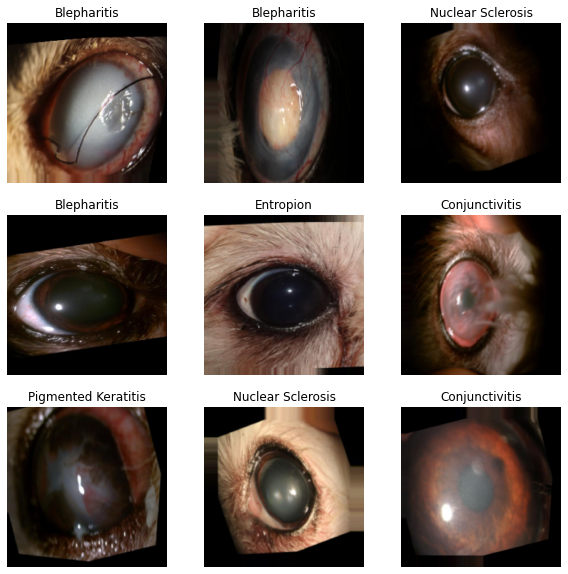

In [22]:
batch = train_generator.next()
images, labels = batch[0], batch[1]

label_names = ['Blepharitis','Conjunctivitis','Entropion','EyelidTumor','HealthyEye','Mastopathy','Nuclear Sclerosis','Pigmented Keratitis']

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    
    label_index = np.argmax(labels[i])
    label = label_names[label_index]
    
    plt.title(label)
    plt.axis("off")
plt.show()


In [23]:
# Build the MobileNetV2 model as a base)
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               163968    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 8)                

In [24]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [25]:
history = model.fit(train_generator, epochs=20, validation_data=val_generator, callbacks=[early_stop])

Epoch 1/20
389/389 [==============================] - 116s 291ms/step - loss: 1.6559 - accuracy: 0.3599 - val_loss: 1.2975 - val_accuracy: 0.5146
Epoch 2/20
389/389 [==============================] - 108s 276ms/step - loss: 1.3613 - accuracy: 0.4459 - val_loss: 1.1761 - val_accuracy: 0.5259
Epoch 3/20
389/389 [==============================] - 108s 277ms/step - loss: 1.2809 - accuracy: 0.4775 - val_loss: 1.1284 - val_accuracy: 0.5608
Epoch 4/20
389/389 [==============================] - 109s 281ms/step - loss: 1.2343 - accuracy: 0.4945 - val_loss: 1.1228 - val_accuracy: 0.5518
Epoch 5/20
389/389 [==============================] - 109s 280ms/step - loss: 1.2021 - accuracy: 0.5061 - val_loss: 1.0869 - val_accuracy: 0.5709
Epoch 6/20
389/389 [==============================] - 110s 281ms/step - loss: 1.1808 - accuracy: 0.5177 - val_loss: 1.0740 - val_accuracy: 0.5721
Epoch 7/20
389/389 [==============================] - 108s 276ms/step - loss: 1.1581 - accuracy: 0.5278 - val_loss: 1.0729 -

In [26]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy}')

18/18 [==============================] - 4s 218ms/step - loss: 1.0405 - accuracy: 0.5979
Test Accuracy: 0.5978647470474243


In [33]:
model.save('MobileNetV2_multi_Skin.h5')

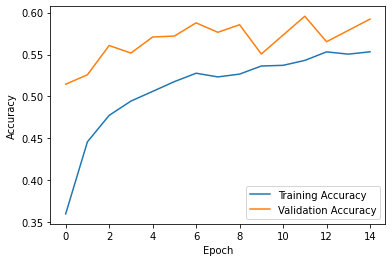

In [27]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

18/18 [==============================] - 4s 214ms/step
Classification Report:
                      precision    recall  f1-score   support

         blepharitis       0.92      0.64      0.76        70
      conjunctivitis       0.49      0.32      0.39        71
           entropion       0.58      0.36      0.44        70
         eyelidTumor       0.76      0.73      0.75        71
             healthy       0.76      0.86      0.81        70
          mastopathy       0.59      0.69      0.64        70
    nuclearSclerosis       0.43      0.76      0.55        70
pigmented  keratitis       0.42      0.43      0.43        70

            accuracy                           0.60       562
           macro avg       0.62      0.60      0.59       562
        weighted avg       0.62      0.60      0.59       562



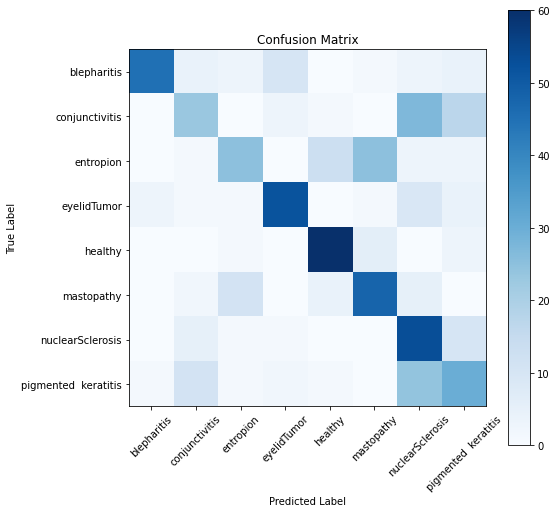

In [28]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(test_generator)

predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

conf_matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
